<a href="https://colab.research.google.com/github/erichan1986/colab/blob/main/BERTopic_Big_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **BERTopic on Large Datasets**

Due to the modularity of BERTopic, it can also be used on large datasets (> 1_000_000) if we change some of the internal algorithms such that they can scale a bit better.

To do so, this example uses Google Colab Pro (T4 with 25GB of VRAM and 26GB of System RAM) and cuML to enable GPU-accelerated machine learning.

First, we will need to install some packages:

In [2]:
%%capture
!pip install git+https://github.com/MaartenGr/BERTopic.git@master

!pip install cudf-cu12 dask-cudf-cu12 --extra-index-url=https://pypi.nvidia.com
!pip install cuml-cu12 --extra-index-url=https://pypi.nvidia.com
!pip install cugraph-cu12 --extra-index-url=https://pypi.nvidia.com
!pip install cupy-cuda12x -f https://pip.cupy.dev/aarch64

!pip install safetensors
!pip install datasets
!pip install datashader
!pip install adjustText

In [14]:
!pip install git+https://github.com/MaartenGr/BERTopic.git@master

  Cloning https://github.com/MaartenGr/BERTopic.git (to revision master) to /tmp/pip-req-build-fe0xsiko
  Running command git clone --filter=blob:none --quiet https://github.com/MaartenGr/BERTopic.git /tmp/pip-req-build-fe0xsiko
  Resolved https://github.com/MaartenGr/BERTopic.git to commit 998ac83e4844989229afa2777dd03c9d8708ab06
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [1]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

Sometimes, it might happen that you get the `NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968` error, if so make sure to run the following code:

```python
import locale
locale.getpreferredencoding = lambda: "UTF-8"
```

**(Optional)** We can mount a personal Google Drive such that we can save the resulting embeddings and models that you create. Although it is not necessary, if you created embeddings and then run into memory errors, it is generally nice to have the embeddings saved somewhere without needing to recalculate them.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Data**

To show how BERTopic can be used with large data, we are going to load in some Wikipedia texts. Cohere has fortunately created a dataset split by paragraphs, which allows us to stay within token limit sizes.

For this example, we load in 1 million texts from Wikipedia and see if we can extract topics from them.

In [ ]:
# from datasets import load_dataset

# # Extract 1 millions records
# lang = 'en'
# data = load_dataset(f"Cohere/wikipedia-22-12", lang, split='train', streaming=True)
# docs = [doc["text"] for doc in data if doc["id"] != "1_000_000"]; len(docs)

1000001

# **Basic Example**

Now that we have our data, we can start with a basic example. This example shows the minimum steps necessary for training a BERTopic model on large datasets. Do note though that memory errors are still possible when tweaking parameters. After this section, some tips and tricks will be mentioned to demonstrate how we can further reduce memory or be more efficient with our training process.

In [10]:
import pandas as pd
docs =pd.read_pickle('/content/drive/MyDrive/NER_Events.pkl')

## Embeddings

Next, we are going to pre-calculate the embeddings as input for our BERTopic model. The reason for doing this is that this input step can take quite some time to compute. If we pre-calculate them and save the resulting embeddings, we can skip over this step when we are iterating over our model.

In [2]:
from sentence_transformers import SentenceTransformer

In [7]:
from sentence_transformers import SentenceTransformer

# Create embeddings
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
embeddings = model.encode(docs, show_progress_bar=True)

Batches:   0%|          | 0/5068 [00:00<?, ?it/s]

We can save the resulting embeddings as follows:

In [9]:
import numpy as np
with open('/content/drive/MyDrive/embeddings.npy', 'wb') as f:
    np.save(f, embeddings)

and then load the embeddings as follows:

In [10]:
import numpy as np
embeddings = np.load('/content/drive/MyDrive/embeddings.npy')

## Prepare Vocab

Before we can start with training our model, there is still something that we can do to reduce the necessary memory. We can prepare our vocabulary beforehand such that the tokenizer does not need to do the calculations itself.

Below, we are essentially creating a vocabulary of words in our dataset and parsing them such that they need to appear at least 15 times in our data.

With sufficient RAM, we could skip over this step but I have found this often helps in reducing the necessary RAM.

**Note**: If you are using a custom CountVectorizer, then it is advised to use that instead of the default CountVectorizer to build the tokenizer.

In [4]:
import collections
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer

# Extract vocab to be used in BERTopic
vocab = collections.Counter()
tokenizer = CountVectorizer().build_tokenizer()
for doc in tqdm(docs):
  vocab.update(tokenizer(doc))
vocab = [word for word, frequency in vocab.items() if frequency >= 15]; len(vocab)

100%|██████████| 162170/162170 [00:00<00:00, 204495.93it/s]


7489

## Train BERTopic

Finally, we can train our BERTopic model. We select the same sentence-transformer model as we did before. Moreover, we select cuML's HDBSCAN and UMAP models. These are GPU-accelerated versions of HDBSCAN and UMAP and allow us to speed training on such a large dataset.

In [9]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [13]:
# docs

In [15]:
from cuml.manifold import UMAP
from cuml.cluster import HDBSCAN
from bertopic import BERTopic

# Prepare sub-models

embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
umap_model = UMAP(n_components=5, n_neighbors=50, random_state=42, metric="cosine", verbose=True)
hdbscan_model = HDBSCAN(min_samples=20, gen_min_span_tree=True, prediction_data=True, min_cluster_size=20, verbose=True)

vectorizer_model = CountVectorizer(vocabulary=vocab, stop_words="english")

# Fit BERTopic without actually performing any clustering
topic_model= BERTopic(
        embedding_model=embedding_model,
        # umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        # vectorizer_model=vectorizer_model,
        representation_model=representation_model,
        verbose=True,
        calculate_probabilities=True,
        min_topic_size=5,
        nr_topics="auto"
).fit_transform(docs)

2024-12-31 12:22:12,457 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/5068 [00:00<?, ?it/s]

2024-12-31 12:23:05,581 - BERTopic - Embedding - Completed ✓
2024-12-31 12:23:05,587 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-12-31 12:27:28,388 - BERTopic - Dimensionality - Completed ✓
2024-12-31 12:27:28,398 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-12-31 12:27:36,639 - BERTopic - Cluster - Completed ✓
2024-12-31 12:27:36,646 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2024-12-31 12:27:40,138 - BERTopic - Representation - Completed ✓
2024-12-31 12:27:40,142 - BERTopic - Topic reduction - Reducing number of topics
2024-12-31 12:27:44,209 - BERTopic - Representation - Fine-tuning topics using representation models.
100%|██████████| 1117/1117 [48:03<00:00,  2.58s/it]
2024-12-31 13:15:53,126 - BERTopic - Representation - Completed ✓
2024-12-31 13:15:53,155 - BERTopic - Topic reduction - Reduced number of topics from 1416 to 1117


and that is it! We can inspect the topics as follows:

In [17]:
topic_model

([1018,
  1018,
  1018,
  1018,
  1018,
  1018,
  1018,
  1018,
  -1,
  48,
  -1,
  -1,
  -1,
  -1,
  608,
  -1,
  -1,
  1082,
  -1,
  48,
  -1,
  -1,
  -1,
  -1,
  1082,
  -1,
  343,
  46,
  594,
  594,
  -1,
  44,
  1057,
  1082,
  150,
  24,
  593,
  -1,
  -1,
  365,
  143,
  214,
  -1,
  -1,
  481,
  1082,
  1082,
  -1,
  150,
  -1,
  48,
  48,
  -1,
  140,
  213,
  -1,
  127,
  608,
  30,
  340,
  140,
  -1,
  123,
  1042,
  -1,
  32,
  1,
  140,
  260,
  -1,
  140,
  128,
  -1,
  608,
  608,
  187,
  99,
  340,
  52,
  48,
  -1,
  1082,
  287,
  167,
  140,
  -1,
  -1,
  485,
  92,
  -1,
  -1,
  78,
  78,
  608,
  608,
  -1,
  -1,
  1,
  66,
  39,
  851,
  -1,
  -1,
  608,
  -1,
  -1,
  -1,
  -1,
  608,
  608,
  140,
  140,
  -1,
  -1,
  -1,
  365,
  -1,
  10,
  64,
  99,
  22,
  -1,
  314,
  -1,
  -1,
  314,
  -1,
  -1,
  608,
  -1,
  -1,
  4,
  -1,
  -1,
  340,
  -1,
  130,
  -1,
  48,
  -1,
  -1,
  -1,
  167,
  608,
  -1,
  277,
  48,
  -1,
  608,
  -1,
  -1,
  130,
  66,
  -1

Lastly, it would be advised to save the model as follows:

In [ ]:
topic_model.save(
    path='/content/drive/MyDrive/model_dir',
    serialization="safetensors",
    save_ctfidf=True,
    save_embedding_model="sentence-transformers/all-MiniLM-L6-v2"
)

# **Advanced Tips & Tricks**

There are a number of advanced tips and tricks that you can use to make it a bit easier and more flexible to train your model at large datasets.

## UMAP

Just like we pre-computed the embeddings, we can pre-reduce the dimensionality of the embeddings with cuML's UMAP and use those.

This saves quite a bit of time since we need to reduce embeddings everytime we run BERTopic.

**NOTE**: Saving those embeddings, as we did before, is generally advised.

In [ ]:
from cuml.manifold import UMAP

# Train model and reduce dimensionality of embeddings
umap_model = UMAP(n_components=5, n_neighbors=15, random_state=42, metric="cosine", verbose=True)
reduced_embeddings = umap_model.fit_transform(embeddings)

Similarly, we can also prepare the UMAP-reduced embeddings for visualizing documents in 2D:

In [ ]:
from cuml.manifold import UMAP

# Train model and reduce dimensionality of embeddings
umap_model = UMAP(n_components=2, n_neighbors=15, random_state=42, metric="cosine", verbose=True)
reduced_embeddings_2d = umap_model.fit_transform(embeddings)

## HDBSCAN

We can even pre-compute the clusters with HDBSCAN and feed them to BERTopic to perform [manual topic modeling](https://maartengr.github.io/BERTopic/getting_started/manual/manual.html). Manual topic modeling with BERTopic means that if we already have labels of topics, we can use those to label them using a variety of [representation models](https://maartengr.github.io/BERTopic/getting_started/representation/representation.html).

BERTopic can still perform inference since inference is done on topic embeddings that are created during `fit`.

In [14]:
from cuml.cluster import HDBSCAN

# Find clusters of semantically similar documents
hdbscan_model = HDBSCAN(min_samples=30, gen_min_span_tree=True, prediction_data=False, min_cluster_size=30, verbose=True)
# clusters = hdbscan_model.fit(reduced_embeddings).labels_

In [ ]:
!pip install tiktoken

## Manual BERTopic

When we have pre-computed labels, we can pass them instead of having to calculate the clusters ourselves. This allows us to skip over the embedding, dimensionality, and clustering steps!

There is one more trick though that we are going to use. We could directly give BERTopic the reduced embeddings but BERTopic will use those to create topic vectors which is not ideal. Instead, we are giving the model the full embeddings and create a custom dimensionality reduction class that will return the reduced embeddings. This gives us the best of both worlds!

In [ ]:
import pandas as pd
docs =pd.read_pickle('/content/drive/MyDrive/NER_Events.pkl')

In [ ]:
from cuml.cluster import HDBSCAN
from sentence_transformers import SentenceTransformer
from bertopic.representation import OpenAI as OpenAIRepresentation
from bertopic import BERTopic
from bertopic.cluster import BaseCluster
from bertopic.representation import KeyBERTInspired
import tiktoken
from openai import OpenAI
class Dimensionality:
  """ Use this for pre-calculated reduced embeddings """
  def __init__(self, reduced_embeddings):
    self.reduced_embeddings = reduced_embeddings

  def fit(self, X):
    return self

  def transform(self, X):
    return self.reduced_embeddings

from cuml.cluster import HDBSCAN

# Find clusters of semantically similar documents
hdbscan_model = HDBSCAN(min_samples=30, gen_min_span_tree=True, prediction_data=False, min_cluster_size=30, verbose=True,        metric='euclidean',
        cluster_selection_method='eom')
# clusters = hdbscan_model.fit(reduced_embeddings).labels_
from google.colab import userdata
key = userdata.get('OPENAI_API_KEY')
client = OpenAI(api_key=key)
tokenizer = tiktoken.encoding_for_model("gpt-4o-mini")
representation_model = OpenAIRepresentation(
    client=client,
    model="gpt-4o-mini",
    delay_in_seconds=2,
    chat=True,
    nr_docs=4,
    doc_length=500,
    tokenizer=tokenizer
)
# Prepare sub-models
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
# umap_model = Dimensionality(reduced_embeddings)
hdbscan_model = BaseCluster()
vectorizer_model = CountVectorizer(vocabulary=vocab, stop_words="english")
# representation_model = KeyBERTInspired()

# Fit BERTopic without actually performing any clustering
topic_model= BERTopic(
        embedding_model=embedding_model,
        # umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        vectorizer_model=vectorizer_model,
        representation_model=representation_model,
        verbose=True
).fit_transform(docs)

In [16]:
import openai
from bertopic import BERTopic
from bertopic.representation import OpenAI

In [ ]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,633881,-1_cast_films_film_movie,"[cast, films, film, movie, 2020, comedy, relea...",[The developers state that the interactive sto...
1,0,18441,0_goalscorer_scored_goals_goal,"[goalscorer, scored, goals, goal, goalkeeper, ...",[Havertz continued to impress during the follo...
2,1,8518,1_khan_actor_raj_shah,"[khan, actor, raj, shah, crore, hai, actress, ...",[Padukone found further success in 2013 when a...
3,2,7521,2_married_divorced_couple_remarried,"[married, divorced, couple, remarried, engaged...","[In 1974, Getty married German Gisela Martine ..."
4,3,6765,3_cast_actress_starred_actor,"[cast, actress, starred, actor, actors, starri...",[Williams has received four Academy Award nomi...
...,...,...,...,...,...
2372,2371,30,2371_paintings_painting_paint_art,"[paintings, painting, paint, art, artist, gall...","[In 1905, O'Keeffe began art training at the S..."
2373,2372,30,2372_tulips_tulip_economists_economic,"[tulips, tulip, economists, economic, bulbs, 1...",[It is well established that prices for tulip ...
2374,2373,30,2373_squads_squad_roster_players,"[squads, squad, roster, players, teams, tourna...",[Each team must name a preliminary squad of be...
2375,2374,30,2374_entrances_subterranean_tunnel_stairs,"[entrances, subterranean, tunnel, stairs, pyra...",[Today tourists enter the Great Pyramid via th...


## Visualize Documents

In [ ]:
import itertools
import pandas as pd

# Define colors for the visualization to iterate over
colors = itertools.cycle(['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000'])
color_key = {str(topic): next(colors) for topic in set(topic_model.topics_) if topic != -1}

# Prepare dataframe and ignore outliers
df = pd.DataFrame({"x": reduced_embeddings_2d[:, 0], "y": reduced_embeddings_2d[:, 1], "Topic": [str(t) for t in topic_model.topics_]})
df["Length"] = [len(doc) for doc in docs]
df = df.loc[df.Topic != "-1"]
df = df.loc[(df.y > -10) & (df.y < 10) & (df.x < 10) & (df.x > -10), :]
df["Topic"] = df["Topic"].astype("category")

# Get centroids of clusters
mean_df = df.groupby("Topic").mean().reset_index()
mean_df.Topic = mean_df.Topic.astype(int)
mean_df = mean_df.sort_values("Topic")

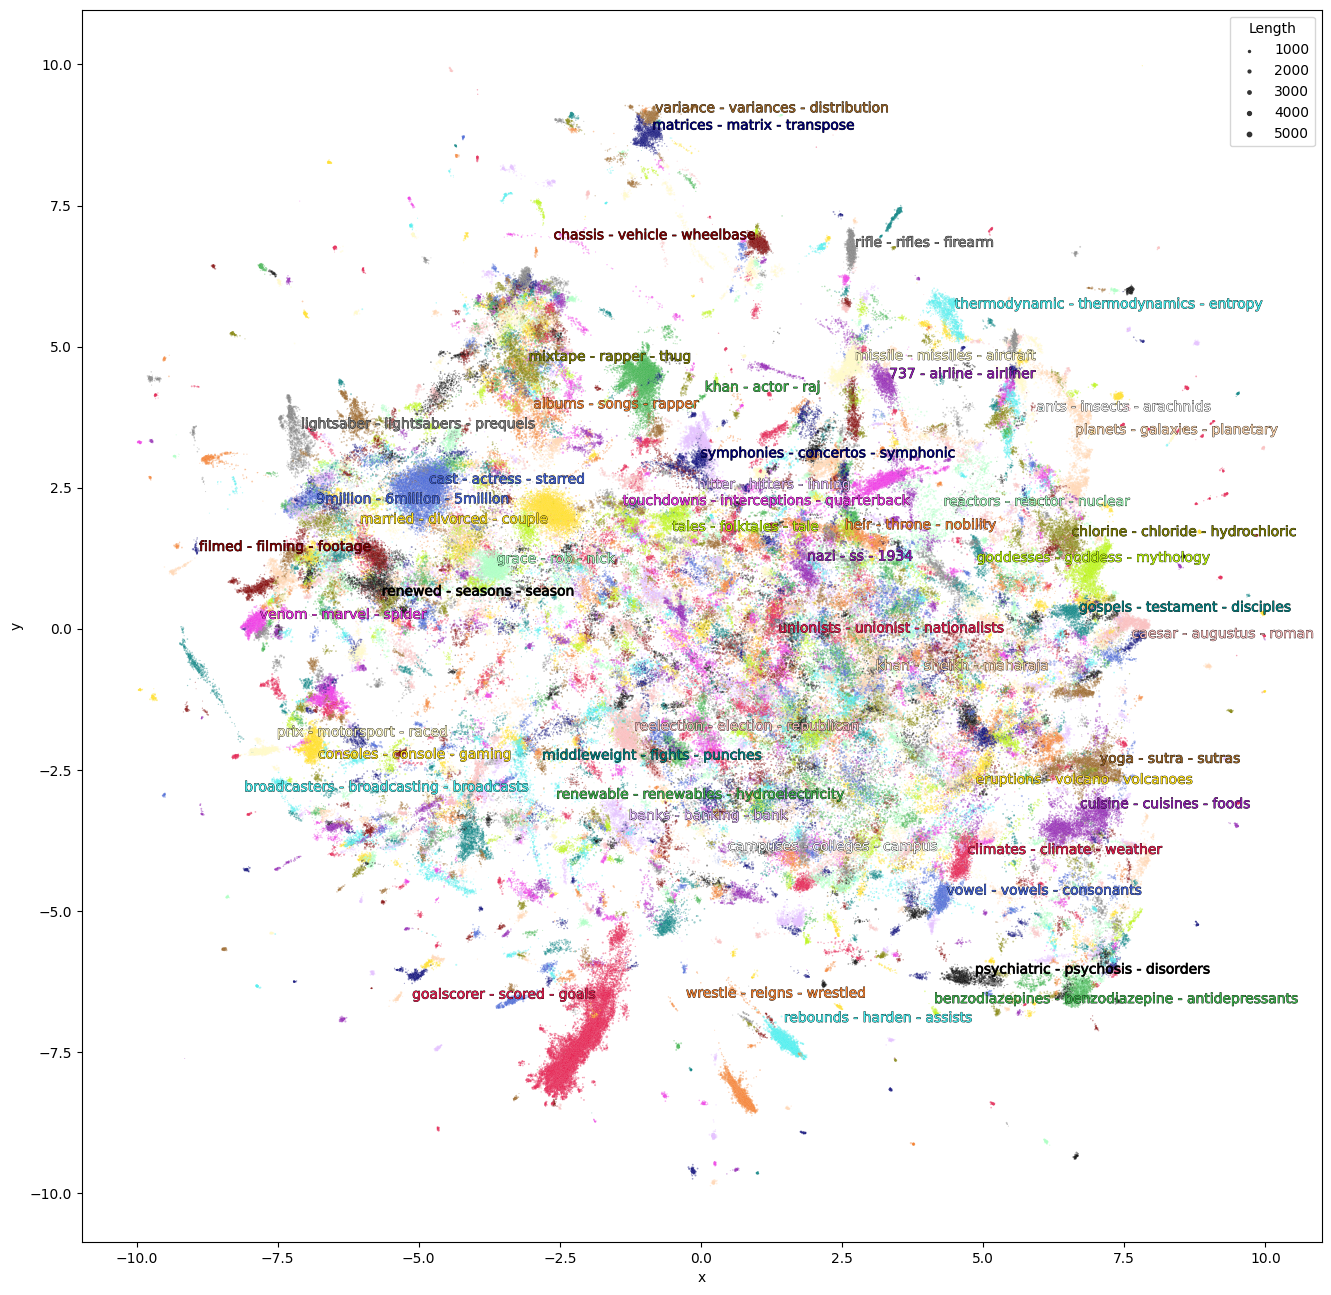

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt
from adjustText import adjust_text
import matplotlib.patheffects as pe

fig = plt.figure(figsize=(16, 16))
sns.scatterplot(data=df, x='x', y='y', c=df['Topic'].map(color_key), alpha=0.4, sizes=(0.4, 10), size="Length")

# Annotate top 50 topics
texts, xs, ys = [], [], []
for row in mean_df.iterrows():
  topic = row[1]["Topic"]
  name = " - ".join(list(zip(*topic_model.get_topic(int(topic))))[0][:3])

  if int(topic) <= 50:
    xs.append(row[1]["x"])
    ys.append(row[1]["y"])
    texts.append(plt.text(row[1]["x"], row[1]["y"], name, size=10, ha="center", color=color_key[str(int(topic))],
                          path_effects=[pe.withStroke(linewidth=0.5, foreground="black")]))

# Adjust annotations such that they do not overlap
adjust_text(texts, x=xs, y=ys, time_lim=1, force_text=(0.01, 0.02), force_static=(0.01, 0.02), force_pull=(0.5, 0.5))
plt.show()
# plt.savefig("visualization2.png", dpi=600)